In [10]:
import math
import time
import random
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
from bessel_zeros import get_bessel_zeros
from CDFs3_working import build_cdfs as _build_cdfs
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [11]:
# ── PARAMETERS ──────────────────────────────────────────────────────────────
T_total = 1.0
DIM     = 3
S       = 1.  # cylinder nondimensional step
N_ZEROS = 10
INV_R   = 2000
INV_T   = 2000
K       = 1.1
s       = 1.0
N_PATHS = 200_000
tol     = 1e-8
_eps    = np.finfo(np.float64).eps

In [12]:
def build_cdfs_checked(dim, S, zeros, INV_R, INV_T):
    out = _build_cdfs(dim, S, zeros, INV_R, INV_T)
    if out is None or not isinstance(out, tuple) or len(out) != 5:
        raise RuntimeError("CDFs3_working.build_cdfs must return 5 outputs")
    r_star, cdf_r, p_surv0, t_star, raw_t = out
    # quick shape/type sanity
    for name, arr in [("r_star", r_star), ("cdf_r", cdf_r), ("t_star", t_star), ("raw_t", raw_t)]:
        if not isinstance(arr, np.ndarray):
            raise TypeError(f"{name} must be numpy array, got {type(arr)}")
    if not np.isfinite(p_surv0):
        raise ValueError(f"p_surv0 is not finite: {p_surv0}")
    return r_star, cdf_r, p_surv0, t_star, raw_t


In [13]:
print("Computing Bessel function zeros…")
zeros = get_bessel_zeros(DIM, N_ZEROS)
print(f" Retrieved {len(zeros)} zeros for ν={DIM/2 -1}")


Computing Bessel function zeros…
 Retrieved 10 zeros for ν=0.5


In [14]:
r_star, cdf_r, p_surv0, t_star, raw_t = build_cdfs_checked(DIM, S, zeros, INV_R, INV_T)
p_surv0 = float(np.clip(p_surv0, 0.0, 1.0))
p_exit0 = 1.0 - p_surv0
p_surv0

0.014383761361077075

In [15]:
u_r = np.linspace(0.0, 1.0, INV_R)
cdf_r = np.maximum.accumulate(np.clip(cdf_r, 0.0, 1.0))
r_star_inv = np.interp(u_r, cdf_r, r_star)

u_t = np.linspace(0.0, 1.0, INV_T)
if p_exit0 > 0.0:
    cond_exit_cdf = np.maximum.accumulate(np.clip(raw_t / p_exit0, 0.0, 1.0))
    t_star_inv = np.interp(u_t, cond_exit_cdf, t_star)
else:
    t_star_inv = np.zeros_like(u_t)


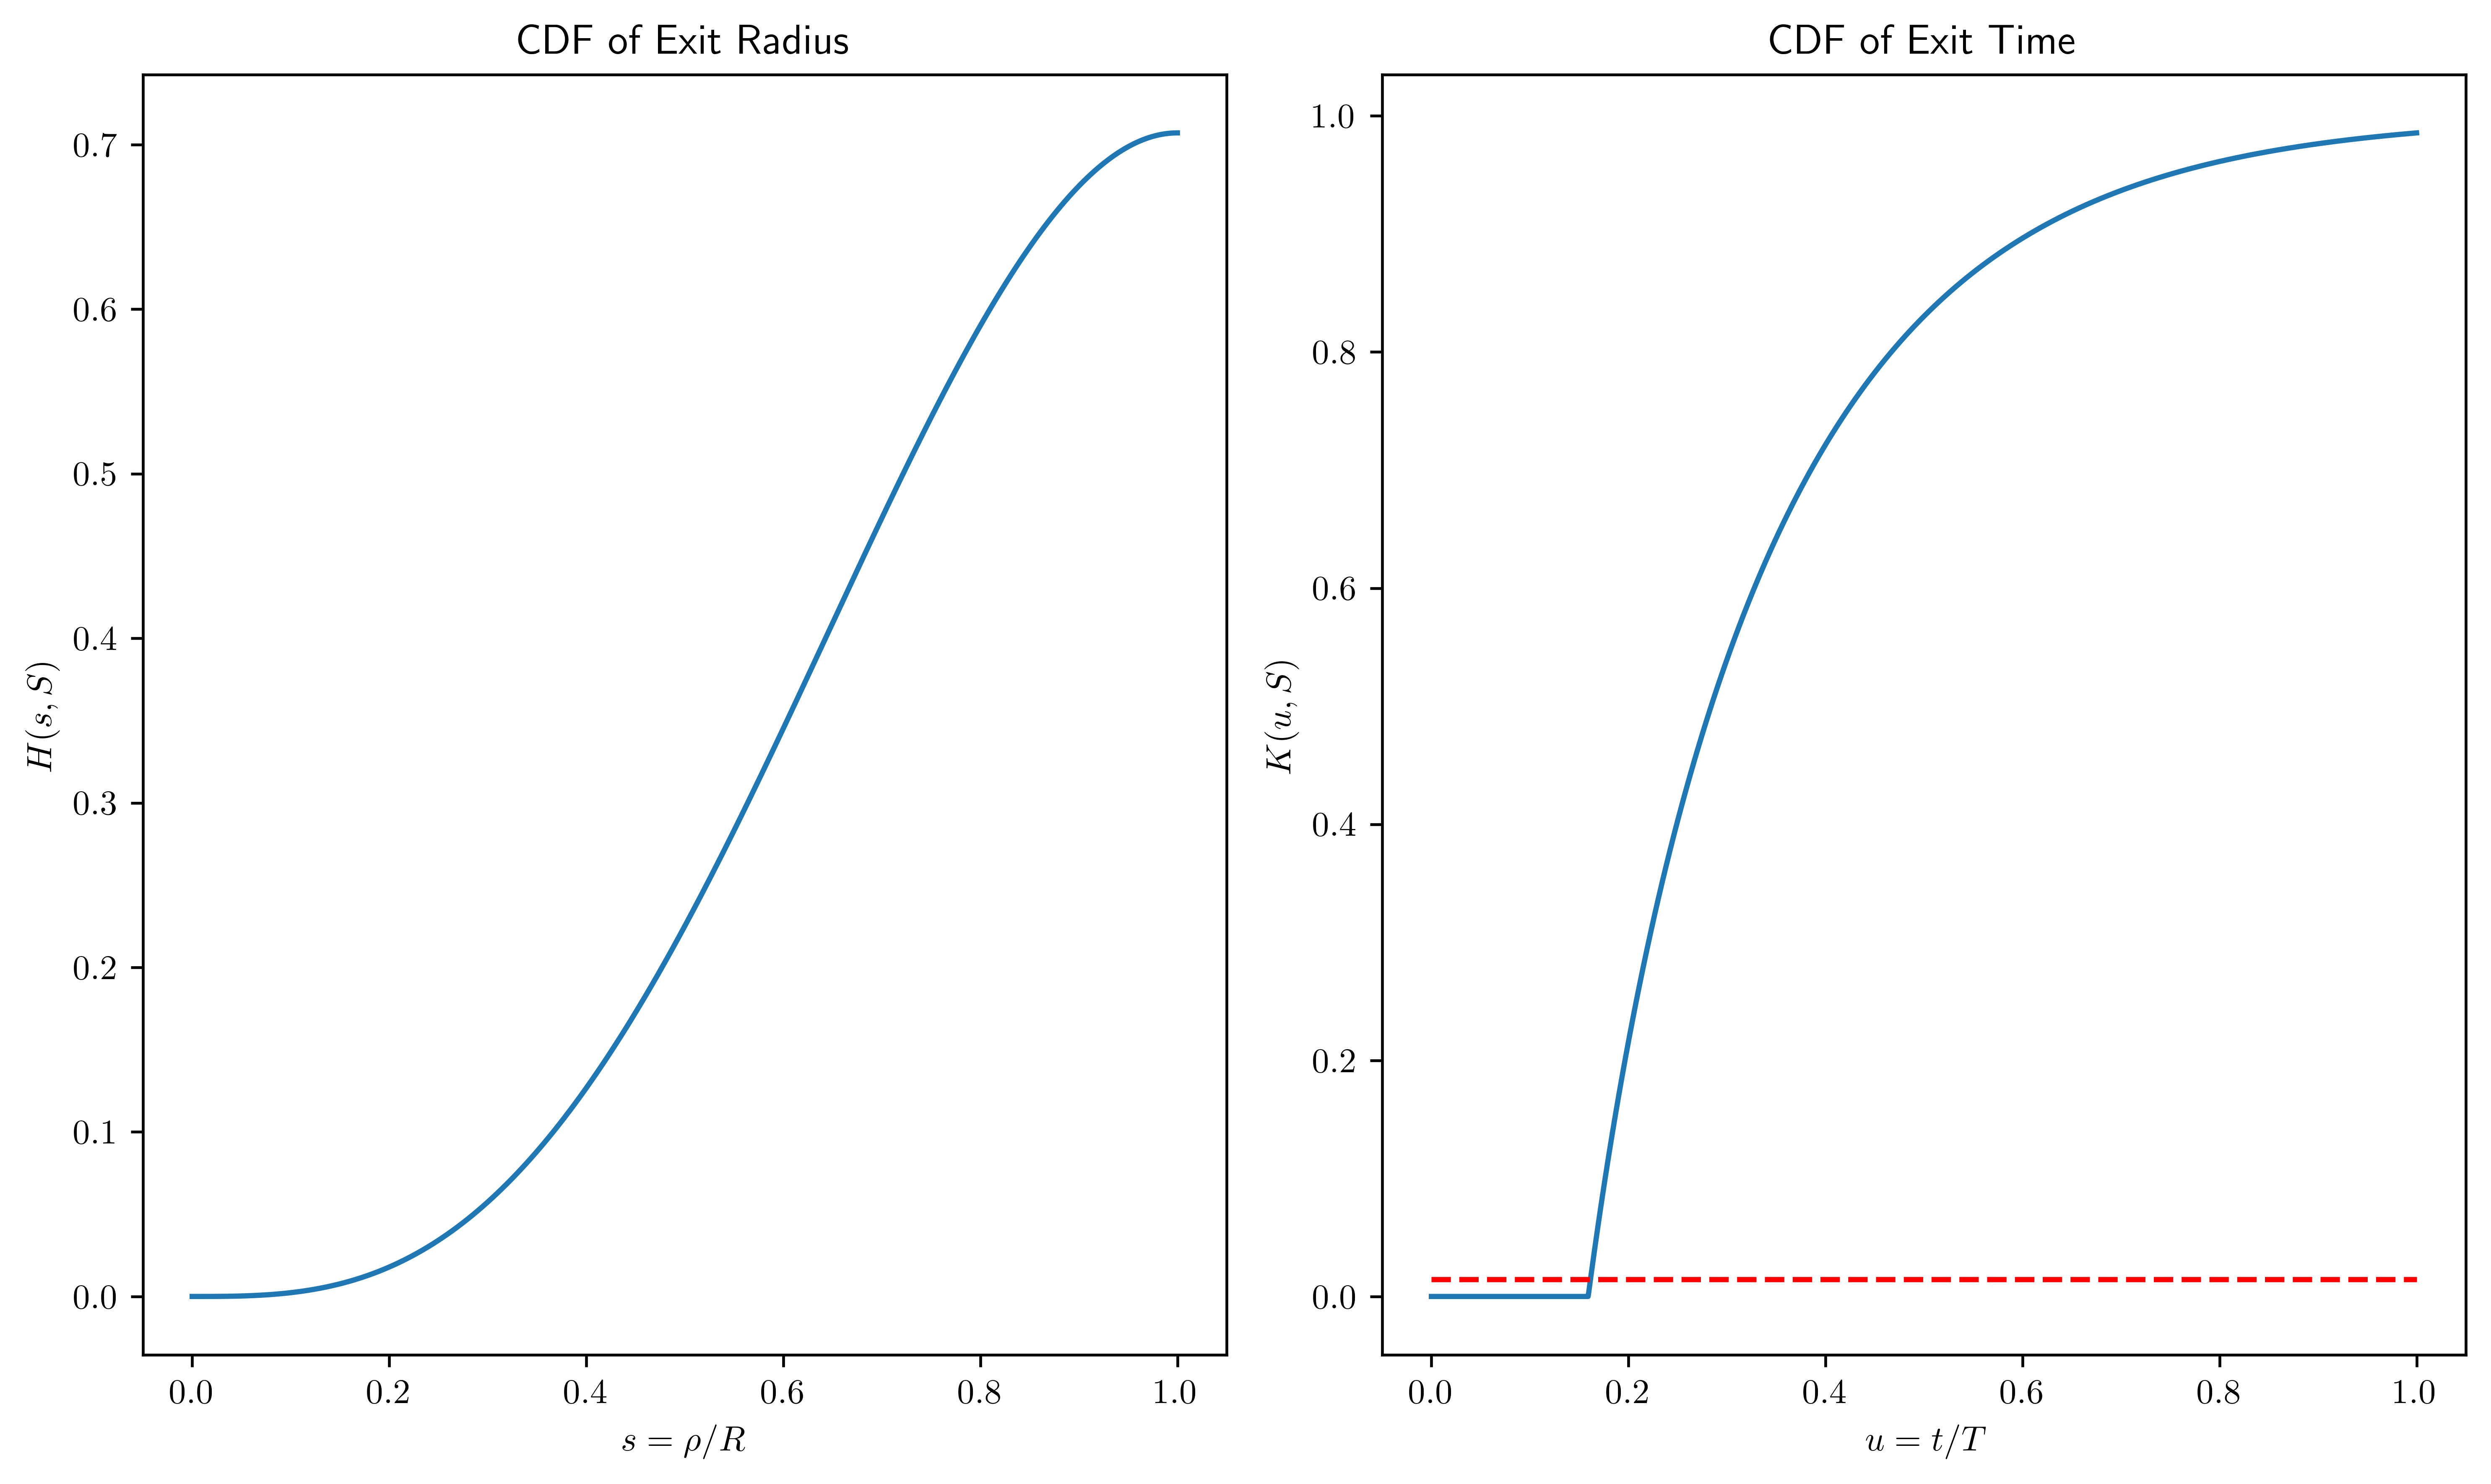

In [16]:
f = plt.figure(figsize=(10, 6),dpi = 600);
ax1 = f.add_subplot(1, 2, 1)
ax1.plot(r_star,cdf_r)
ax1.set_title('CDF of Exit Radius')
ax1.set_xlabel(r'$s=\rho/R$')
ax1.set_ylabel(r'$H(s,S)$');
ax2 = f.add_subplot(1, 2, 2)
# ind = np.where(raw_t>.9999999999)[0][0]
ax2.plot(t_star,raw_t)
ax2.hlines(p_surv0,0,1,colors='r',linestyles='dashed')
ax2.set_title('CDF of Exit Time')
ax2.set_xlabel(r'$u=t/T$')
ax2.set_ylabel(r'$K(u,S)$');
plt.tight_layout()
plt.savefig('CDFs.png',bbox_inches='tight')